<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_2_1_MLP_earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from psutil import virtual_memory,cpu_percent
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print('Current system-wide CPU utilization %: ',cpu_percent())
#Remove all warning
import warnings
warnings.filterwarnings("ignore")

Your runtime has 8.4 gigabytes of available RAM

Current system-wide CPU utilization %:  9.4


In [6]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from collections import Counter

# Loading datasets
from io import StringIO, BytesIO
from zipfile import ZipFile
import urllib.request

# Preprocessing
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Machine learning algos
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Imblearn
from imblearn.metrics import geometric_mean_score

# Grid search
from tensorflow.keras.optimizers import Adam
# Tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow import feature_column  # for data wrangling
from tensorflow.keras.layers import Dense,Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseCategoricalAccuracy



2.3.0


In [8]:
def url2pd(link):
    with ZipFile(link) as my_zip_file:
        for contained_file in my_zip_file.namelist():
            fzip=my_zip_file.open(contained_file)
            data=fzip.read()
    s=str(data,'utf-8')
    data = StringIO(s) 
    print('Done loading a dataset!')
    return pd.read_csv(data)

In [9]:
filenames = os.listdir('./Data')
filenames

['Prepared Texas 2019.zip', 'Surveys on papers.xlsx', 'Term.xlsx']

In [10]:
# Load data
url_1 = './Data/' + filenames[0]
df = url2pd(url_1)
df.info()
df.head(3)

Done loading a dataset!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949856 entries, 0 to 949855
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Prsn_Injry_Sev     949856 non-null  int64 
 1   Prsn_Age           949856 non-null  int64 
 2   Prsn_Gndr          949856 non-null  object
 3   Wthr_Cond          949856 non-null  object
 4   Light_Cond         949856 non-null  object
 5   Surf_Cond          949856 non-null  object
 6   Veh_Body_Styl      949856 non-null  object
 7   Prsn_Rest          949856 non-null  object
 8   Prsn_Drg_Rslt      949856 non-null  object
 9   Harm_Evnt          949856 non-null  object
 10  Rural              949856 non-null  int64 
 11  Crash_Speed_Limit  949856 non-null  int64 
 12  Road_Algn          949856 non-null  object
 13  Veh_Mod_Year       949856 non-null  int64 
 14  Weekend            949856 non-null  int64 
 15  Crash_season       949856 non-null  int64 
 

,Prsn_Injry_Sev,Prsn_Age,Prsn_Gndr,Wthr_Cond,Light_Cond,Surf_Cond,Veh_Body_Styl,Prsn_Rest,Prsn_Drg_Rslt,Harm_Evnt,Rural,Crash_Speed_Limit,Road_Algn,Veh_Mod_Year,Weekend,Crash_season,Part_of_day,Collsn_type,Collsn_name
0,0,26,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",33,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
1,0,52,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",19,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
2,0,27,FEMALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",16,1,3,4,SAME DIRECTION,BOTH LEFT TURN


In [17]:
# Let's just use 50% of the total dataset
df, _ = train_test_split(df, test_size=0.5,stratify = df['Prsn_Injry_Sev'])
df.shape

(474928, 19)

In [18]:
y = df['Prsn_Injry_Sev']
print('All target values:')
print(y.value_counts())
X = df.drop(columns=['Prsn_Injry_Sev'])

All target values:
0    396279
1     51204
2     22621
3      3976
4       848
Name: Prsn_Injry_Sev, dtype: int64


In [19]:
# %% Data wrangling -------------
# Classify variable type
emb_vars, ind_vars, num_vars = [], [], []
for var in X.columns:
    if X[var].dtypes == 'O':
        if len(X[var].unique()) > 5:
            emb_vars.append(var)
        else:
            ind_vars.append(var)
    else:
        num_vars.append(var)
print('Numerical variables are ', num_vars)
print('Categorical variables that have at most 5 categories are ', ind_vars)
print('Categorical variables that have more than 5 categories are ', emb_vars)

# Create feature columns
feature_columns = []
# numeric cols
for header in num_vars:
    feature_columns.append(feature_column.numeric_column(header))
# bucketized cols
# age = feature_column.numeric_column('Prsn_Age')
# age_buckets = feature_column.bucketized_column(age, boundaries=[16, 22, 35, 55, 65])
# feature_columns.append(age_buckets)
# indicator_columns
for col_name in ind_vars:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
# embedding columns
for col_name in emb_vars:
    emb_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    col_embedding = feature_column.embedding_column(emb_column, dimension=5)
    feature_columns.append(col_embedding)

# Convert all setup into new dataset
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
X = feature_layer(dict(X)).numpy()
print('New shape of the input data set:',X.shape)

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
Categorical variables that have at most 5 categories are  ['Prsn_Gndr', 'Prsn_Drg_Rslt', 'Collsn_type']
Categorical variables that have more than 5 categories are  ['Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Harm_Evnt', 'Road_Algn', 'Collsn_name']
New shape of the input data set: (474928, 59)


In [20]:
# %% Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=48)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

# %% standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training features shape: (303953, 59)
Validation features shape: (75989, 59)
Test features shape: (94986, 59)


# ALL mini functions



In [21]:
# Import Metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score

# %% Function to compare the prediction and true labels
def get_accs(label, pred_proba, tr_time=0,index=None):
    prediction = pred_proba.argmax(axis=1)
    cm = confusion_matrix(label, prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm) / len(label)
    ind_accs = cm / np.sum(cm, axis=1)[:, np.newaxis]
    accs = [ind_accs[i, i] for i in range(length)]
    cols = ['Class {}'.format(i) for i in range(length)]
    # Global accuracy
    accs.append(glb_acc)
    # AUC
    accs.append(roc_auc_score(label, pred_proba,multi_class='ovr'))
    # G-mean
    accs.append(geometric_mean_score(label, prediction, correction=0.001))
    # Average perf
    accs.append(np.mean(accs[-3:]))
    # Training time
    accs.append(np.round(tr_time,3))
    cols = cols + ['Accuracy','AUC','G-mean','Avg_Pfm','Training Time']

    out = np.array(accs).reshape(1, len(accs))
    return pd.DataFrame(out, columns=cols,index=[index])

# ML with class weight

In [22]:
wgt='balanced'
clfs = [LogisticRegression(solver = 'lbfgs',class_weight=wgt),
        DecisionTreeClassifier(class_weight=wgt),
        RandomForestClassifier(max_depth=4,class_weight=wgt)]
clf_names = ['LR','DT','RF']
rsts = pd.DataFrame()
for model, name in zip(clfs,clf_names):
    start = time.time()
    print(name)
    model.fit(X_train, y_train.values)
    end= time.time()
    # use the model to make predictions with the test data
    Y_pred = model.predict_proba(X_test)

    # get the evaluation metrics
    rsts = rsts.append(get_accs(y_test.values,Y_pred,end-start,name))    
print(rsts.iloc[:,5:])

LR
DT
RF
    Accuracy       AUC    G-mean   Avg_Pfm  Training Time
LR  0.500421  0.709277  0.359736  0.523145         12.196
DT  0.714453  0.532548  0.144966  0.463989          6.041
RF  0.552418  0.670414  0.280327  0.501053         18.104


# MLP functions


In [23]:
# Add weights
weights = len(y_train) / (5 * np.bincount(y_train))
cls_wgt = dict(zip(np.arange(5), weights))
cls_wgt

{0: 0.23969355487386543,
 1: 1.8550686603600854,
 2: 4.198825804669153,
 3: 23.886286836935167,
 4: 112.15977859778597}

In [24]:
def early_stops(metric_name):
    es = EarlyStopping(monitor='val_'+ metric_name,
                   verbose=1, patience=10, mode='max',
                   restore_best_weights=True)
    return es

In [25]:
# Constant
EPOCH = 50
BATCH_SIZE = 2048
VERBOSE = 0

In [26]:
def create_mlp():
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1],
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
               )
    return MLP

In [27]:
Y_pred = 0
for i in range(3):
    model = create_mlp()
    start = time.time()
    monitor = model.fit(X_train, y_train.values,
                        callbacks=[early_stops('accuracy')],
                        class_weight = cls_wgt,
                        validation_data=(X_val, y_val.values),
                        batch_size=BATCH_SIZE,
                        verbose=VERBOSE, epochs=EPOCH
                       )
    end = time.time()
    # use the model to make predictions with the test data
    Y_pred+= model.predict(X_test)
rsts = rsts.append(get_accs(y_test.values,Y_pred/3,end-start,'MLP-'+str(i+1)))
rsts

Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping


,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,Avg_Pfm,Training Time
LR,0.533903,0.412362,0.140805,0.320755,0.605882,0.500421,0.709277,0.359736,0.523145,12.196
DT,0.831584,0.146372,0.088196,0.038994,0.152941,0.714453,0.532548,0.144966,0.463989,6.041
RF,0.612534,0.330144,0.041556,0.301887,0.682353,0.552418,0.670414,0.280327,0.501053,18.104
MLP-3,0.558507,0.374378,0.052829,0.260377,0.717647,0.512360,0.675292,0.290366,0.492673,3.005


# Compare different feature encodings

- 1 hot encoding
- 1h + embedding3
- 1h + e5
- 1h + e7 

## Prepare data

In [28]:
X = df.drop(columns=['Prsn_Injry_Sev']).copy()

In [29]:
list(X.dtypes[X.dtypes!='O'].index)

['Prsn_Age',
 'Rural',
 'Crash_Speed_Limit',
 'Veh_Mod_Year',
 'Weekend',
 'Crash_season',
 'Part_of_day']

In [30]:
def data_encode(dim=None):
    X = df.drop(columns=['Prsn_Injry_Sev']).copy()
    num_vars = list(X.dtypes[X.dtypes!='O'].index)
    cate_vars = list(X.dtypes[X.dtypes=='O'].index)
    emb_vars, ind_vars = [], []
    if dim == None:
        ind_vars = cate_vars.copy()
    else:
        for var in cate_vars:
            if len(X[var].unique()) > dim:
                emb_vars.append(var)
            else:
                ind_vars.append(var)
    print('Numerical variables are ', num_vars)
    print('One-hot encoding variables are ', ind_vars)
    print('Embedding variables are ', emb_vars)
    # Create feature columns
    feature_columns = []
    # numeric cols
    for header in num_vars:
        feature_columns.append(feature_column.numeric_column(header))
    # indicator_columns
    for col_name in ind_vars:
        categorical_column = feature_column.categorical_column_with_vocabulary_list(
            col_name, X[col_name].unique())
        indicator_column = feature_column.indicator_column(categorical_column)
        feature_columns.append(indicator_column)
    # embedding columns
    for col_name in emb_vars:
        emb_column = feature_column.categorical_column_with_vocabulary_list(
            col_name, X[col_name].unique())
        col_embedding = feature_column.embedding_column(emb_column, dimension=dim)
        feature_columns.append(col_embedding)

    # Convert all setup into new dataset
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    X = feature_layer(dict(X)).numpy()
    print('New shape of the input data set:',X.shape)
    return X
# Test function
data_encode();

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
One-hot encoding variables are  ['Prsn_Gndr', 'Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Prsn_Drg_Rslt', 'Harm_Evnt', 'Road_Algn', 'Collsn_type', 'Collsn_name']
Embedding variables are  []
New shape of the input data set: (474928, 116)


In [31]:
embedded_vars = [None, 3, 5, 7]
rsts = pd.DataFrame()
y = df['Prsn_Injry_Sev'].copy()

In [32]:
for emb in embedded_vars:
    print(emb)
    X = data_encode(emb)
    # %% Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=48)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=48)

    print('Training features shape:', X_train.shape)
    print('Validation features shape:', X_val.shape)
    print('Test features shape:', X_test.shape)

    # %% standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    clfs = [LogisticRegression(solver = 'lbfgs',class_weight=wgt),
            DecisionTreeClassifier(class_weight=wgt),
            RandomForestClassifier(max_depth=4,class_weight=wgt)]
    clf_names = ['LR','DT','RF']
    for model, name in zip(clfs,clf_names):
        start = time.time()
        print(name)
        model.fit(X_train, y_train.values)
        end= time.time()
        # use the model to make predictions with the test data
        Y_pred = model.predict_proba(X_test)

        # get the evaluation metrics
        rsts = rsts.append(get_accs(y_test.values,Y_pred,end-start,name+'-'+str(emb)))    
    Y_pred = 0
    for i in range(3):
        print('MLP#'+str(i))
        model = create_mlp()
        start = time.time()
        monitor = model.fit(X_train, y_train.values,
                            callbacks=[early_stops('accuracy')],
                            class_weight = cls_wgt,
                            validation_data=(X_val, y_val.values),
                            batch_size=BATCH_SIZE,
                            verbose=VERBOSE, epochs=EPOCH
                        )
        end = time.time()
        # use the model to make predictions with the test data
        Y_pred+= model.predict(X_test)
    rsts = rsts.append(get_accs(y_test.values,Y_pred/3,end-start,'MLP-'+str(emb)))
    print(rsts.iloc[:,5:])

None
Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
One-hot encoding variables are  ['Prsn_Gndr', 'Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Prsn_Drg_Rslt', 'Harm_Evnt', 'Road_Algn', 'Collsn_type', 'Collsn_name']
Embedding variables are  []
New shape of the input data set: (474928, 116)
Training features shape: (303953, 116)
Validation features shape: (75989, 116)
Test features shape: (94986, 116)
LR
DT
RF
MLP#0
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
MLP#1
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
MLP#2
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
          Accuracy       AUC    G-mean   Avg_Pfm  Training Time
LR-None   0.495757  0.715482  0.366742  0.525994         13.759
DT-None   0.712789  0.531643  0.138978  0.461137          8.597
RF-None   0.530299  0

In [33]:
rsts = rsts.reset_index()

In [34]:
indexing = rsts['index'].str.split('-',expand=True)
indexing.columns = ['Model', 'Embedding']


In [35]:
rsts = pd.concat((rsts, indexing),axis =1)

<AxesSubplot:xlabel='Embedding', ylabel='Avg_Pfm'>

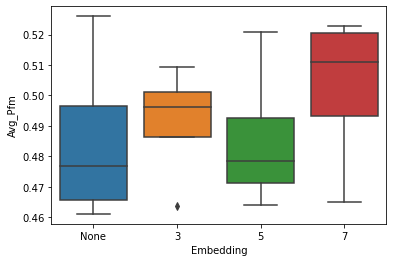

In [36]:
sns.boxplot(data=rsts, x='Embedding',y='Avg_Pfm')

<AxesSubplot:xlabel='Embedding', ylabel='Training Time'>

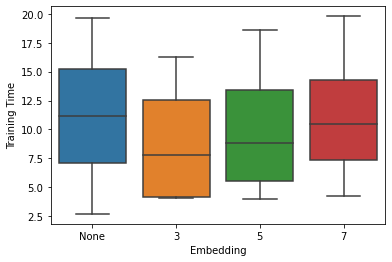

In [37]:
sns.boxplot(data=rsts, x='Embedding',y='Training Time')

In [38]:
rsts.columns =['index', 'Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4',
       'Accuracy', 'AUC', 'G-mean', 'OP score', 'Training Time', 'Model',
       'Embedding']

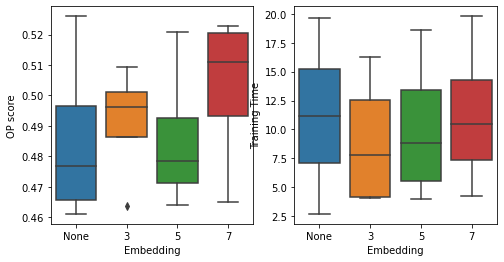

In [41]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.boxplot(data=rsts, x='Embedding',y='OP score')
plt.subplot(1,2,2)
sns.boxplot(data=rsts, x='Embedding',y='Training Time')
plt.savefig('.\Output\DataEncode.png',bbox_inches='tight',dpi=200)
plt.show()

In [42]:
rsts.to_csv('.\Output\VCA_DataEncode.csv',index=False)